# Numerical PDE solution using Physics-informed neural networks

In [1]:
import torch
import numpy as np
from heat_612 import heat_nn


np.random.seed(238)
torch.manual_seed(301)

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 1D Heat equation

In [3]:
### PDE parameters

# dimension
dim=1

# diffusion coefficient
kappa = 0.1

# initial condition
u_0 = lambda x: torch.sin(torch.pi * x) + torch.sin(4 * torch.pi * x)

# right hand side of the equation
rhs = lambda x, t: torch.sin(torch.pi * x)

# analytic solution
u_analytic = lambda x, t: (1 - 1 / (0.1 * torch.pi**2)) * torch.sin(torch.pi * x) * torch.exp(-torch.pi**2 * 0.1 * t
                    ) + torch.sin(4 * torch.pi * x) * torch.exp(- 16 * torch.pi**2 * 0.1 * t
                    ) + 1 / (0.1 * torch.pi**2) * torch.sin(torch.pi * x)

In [6]:
### Construct the neural network and train it

layers = [32, 64, 128, 128, 1]
#in this example: the output layer uses identity as activation func and all the hidden layers use tanh
activations = [torch.tanh]*(len(layers)-1) + [None]

pde_nn = heat_nn(layers, activations, dim, u_0, kappa, rhs)
pde_nn.set_analytic_solution(u_analytic)
N_colloc = 100
pde_nn.set_data(N_colloc)

# gives relatively good results (compared to other parameters, still bad though)
pde_nn.train(lr=1e-2, weight_decay=0.0, epochs = 400, opt_time_scale =True, print_epochs=50)
# LBFGS needs approximately 100 epochs, 30 iterations for kappa = 1
# if kappa = 0.1, better choose more iterations, less epochs
pde_nn.train_lbfgs(lr=1, opt_time_scale = True, epochs=10, max_iter=50)

Epoch 0, Loss: 47.485718, MSE: 0.188377
Epoch 50, Loss: 32.347153, MSE: 0.136993
Epoch 100, Loss: 14.934063, MSE: 0.077773
Epoch 150, Loss: 8.930885, MSE: 0.042546
Epoch 200, Loss: 5.772765, MSE: 0.020272
Epoch 250, Loss: 4.092632, MSE: 0.011024
Epoch 300, Loss: 2.749812, MSE: 0.006851
Epoch 350, Loss: 1.892778, MSE: 0.005370
Epoch 399, Loss: 1.564614, MSE: 0.004845
Epoch 0, Loss: 0.239754, MSE: 0.000168
Epoch 1, Loss: 0.044403, MSE: 0.000038
Epoch 2, Loss: 0.010843, MSE: 0.000009
Epoch 3, Loss: 0.005457, MSE: 0.000004
Epoch 4, Loss: 0.002898, MSE: 0.000002
Epoch 5, Loss: 0.001832, MSE: 0.000001
Epoch 6, Loss: 0.001141, MSE: 0.000001
Epoch 7, Loss: 0.000862, MSE: 0.000000
Epoch 8, Loss: 0.000713, MSE: 0.000000
Epoch 9, Loss: 0.000584, MSE: 0.000000


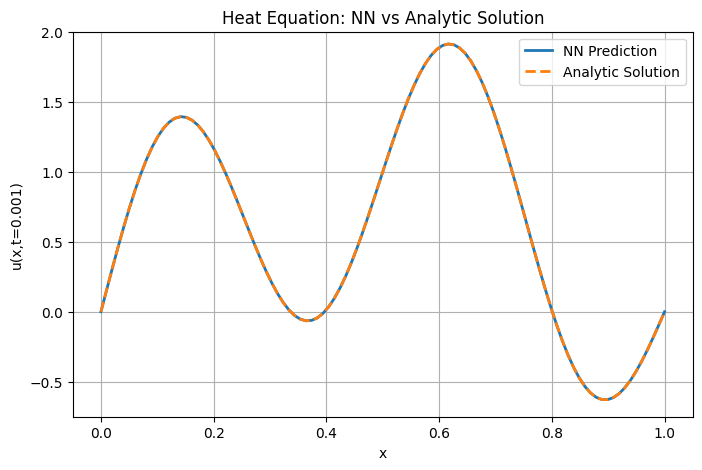

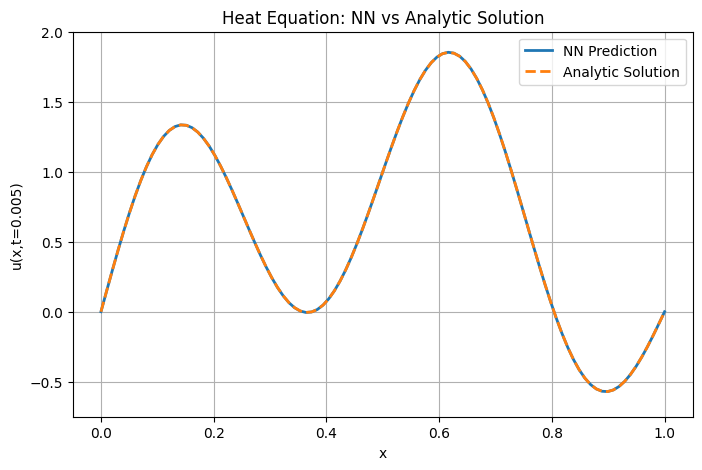

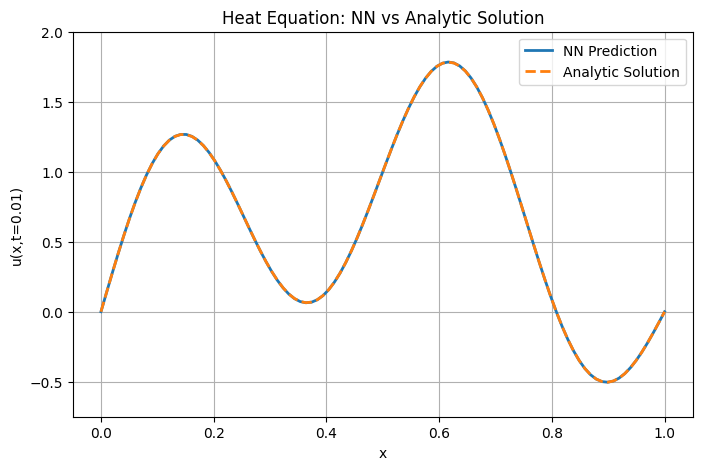

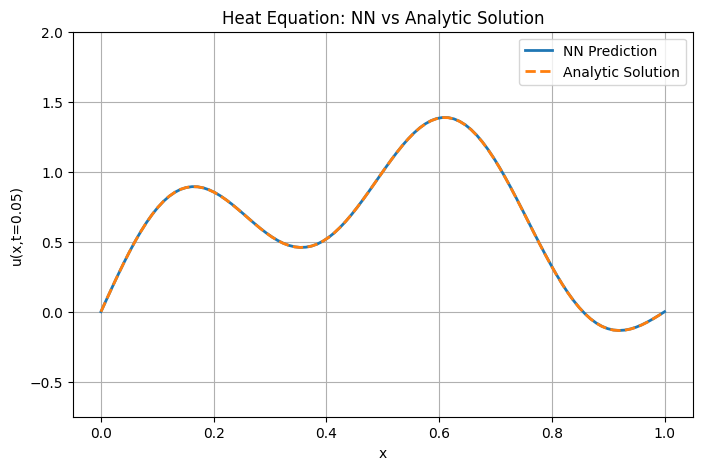

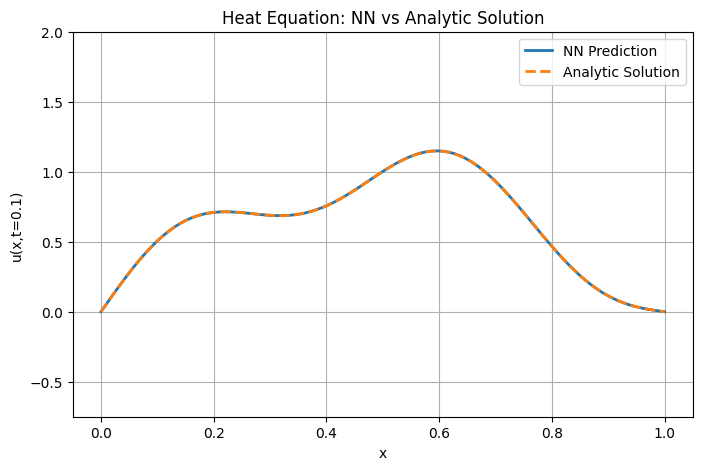

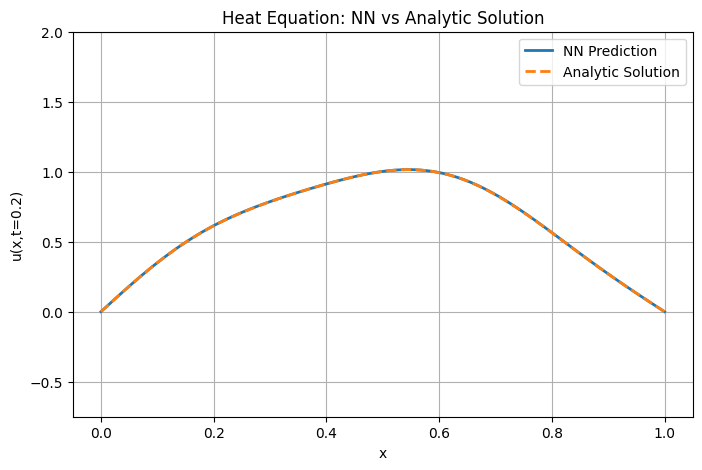

L^2 error:         0.00045121976
L_^{infty}_error:  0.0014808178
2.0359931e-07
2.825415e-07


In [7]:
### Plot results

for t in [0.001, 0.005, 0.01, 0.05, 0.1, 0.2]:
    x_test = torch.linspace(0,1,100).view(-1,1)
    t_test = torch.tensor([[t]]*100)  # t=0.5
    u_pred = pde_nn.trial_solution(x_test, t_test).detach().numpy()

    # compare results with analytic solution

    x_np = x_test.numpy().flatten()  # convert to 1D array for plotting
    t_val = t
    u_analytic_val = pde_nn.u_analytic(x_test, t_test)

    # Plot neural network approximation and analytic solution
    plt.figure(figsize=(8,5))
    plt.plot(x_np, u_pred, label='NN Prediction', linewidth=2)
    plt.plot(x_np, u_analytic_val, '--', label='Analytic Solution', linewidth=2)
    plt.xlabel('x')
    plt.ylabel(f'u(x,t={t})')
    plt.ylim(-0.75, 2.0)
    plt.title('Heat Equation: NN vs Analytic Solution')
    plt.legend()
    plt.grid(True)
    plt.show()

### error measured in L^2 and L^{\infty} norm
L_2_err = pde_nn.L_2_error()
L_infty_err = pde_nn.L_infty_error()
print("L^2 error:        ", L_2_err)
print("L_^{infty}_error: ", L_infty_err)

# MSE
print(pde_nn.mse())
print(pde_nn.mse(x_test, t_test))

# 2D Problem

In [3]:
"""
2D Heat equation
"""

u_0 = lambda x, y: torch.sin(torch.pi * x) * torch.sin(torch.pi * y) + torch.sin(
        2 * torch.pi * x) * torch.sin(4 * torch.pi * y)

u_analytic = lambda x, y,t: torch.sin(torch.pi * x) * torch.sin(torch.pi * y) * torch.exp(
    -2 * kappa * torch.pi**2 * t) + torch.sin(2 * torch.pi * x) * torch.sin(4 * torch.pi * y 
    ) * torch.exp(-20 * kappa * torch.pi**2 * t)

dim=2
kappa = 0.1
rhs = lambda x, y, t: 0

In [4]:
layers = [32, 64, 128, 128, 1]
activations = [torch.tanh]*(len(layers)-1) + [None]

pde_nn = heat_nn(layers, activations, dim, u_0, kappa, rhs)
pde_nn.set_analytic_solution(u_analytic)
N_colloc = 30
pde_nn.set_data(N_colloc)

pde_nn.train(lr=1e-2, weight_decay=0.0, epochs = 500, opt_time_scale =True, print_epochs=50)
pde_nn.train_lbfgs(lr=1, opt_time_scale = True, epochs=20, max_iter=50)

x_test = torch.linspace(0,1,100).view(-1,1)
y_test = torch.linspace(0,1,100).view(-1,1)
t_test = torch.tensor([[0.001]]*100)  # t=0.001
u_pred = pde_nn.trial_solution(x_test, y_test, t_test).detach().numpy()

Epoch 0, Loss: 35.943531, MSE: 0.086549
Epoch 50, Loss: 31.768658, MSE: 0.096081
Epoch 100, Loss: 25.018791, MSE: 0.093722
Epoch 150, Loss: 17.165930, MSE: 0.053195
Epoch 200, Loss: 6.857799, MSE: 0.015054
Epoch 250, Loss: 4.095201, MSE: 0.007181
Epoch 300, Loss: 3.149576, MSE: 0.004912
Epoch 350, Loss: 2.646243, MSE: 0.003854
Epoch 400, Loss: 2.297526, MSE: 0.003170
Epoch 450, Loss: 2.014873, MSE: 0.002833
Epoch 499, Loss: 1.770026, MSE: 0.002327
Epoch 0, Loss: 1.242576, MSE: 0.001558
Epoch 1, Loss: 0.763913, MSE: 0.000717
Epoch 2, Loss: 0.489651, MSE: 0.000342
Epoch 3, Loss: 0.342387, MSE: 0.000187
Epoch 4, Loss: 0.253144, MSE: 0.000133
Epoch 5, Loss: 0.197405, MSE: 0.000097
Epoch 6, Loss: 0.153543, MSE: 0.000069
Epoch 7, Loss: 0.126948, MSE: 0.000072
Epoch 8, Loss: 0.103673, MSE: 0.000045
Epoch 9, Loss: 0.086931, MSE: 0.000032
Epoch 10, Loss: 0.074999, MSE: 0.000029
Epoch 11, Loss: 0.064409, MSE: 0.000023
Epoch 12, Loss: 0.054681, MSE: 0.000020
Epoch 13, Loss: 0.047234, MSE: 0.00001

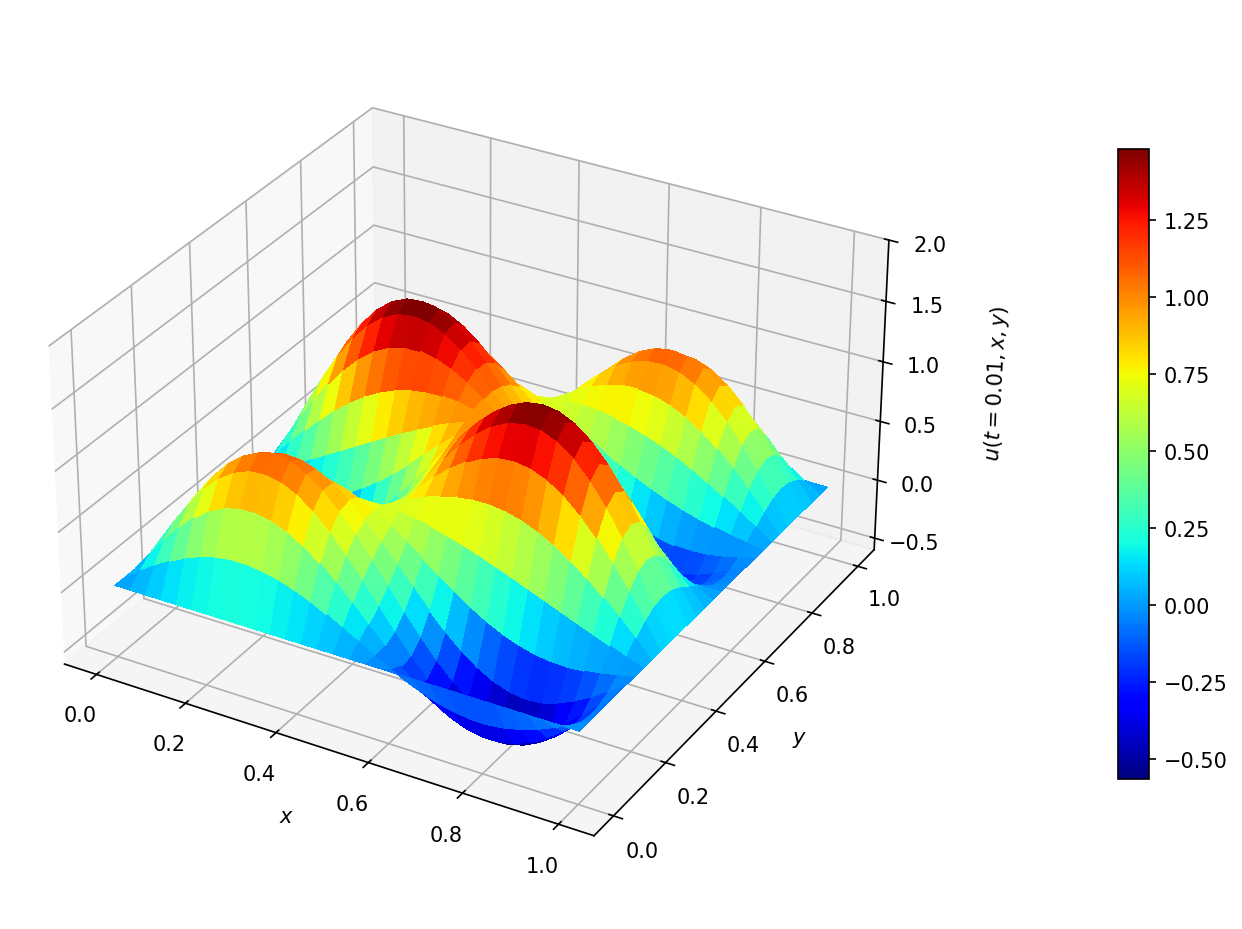

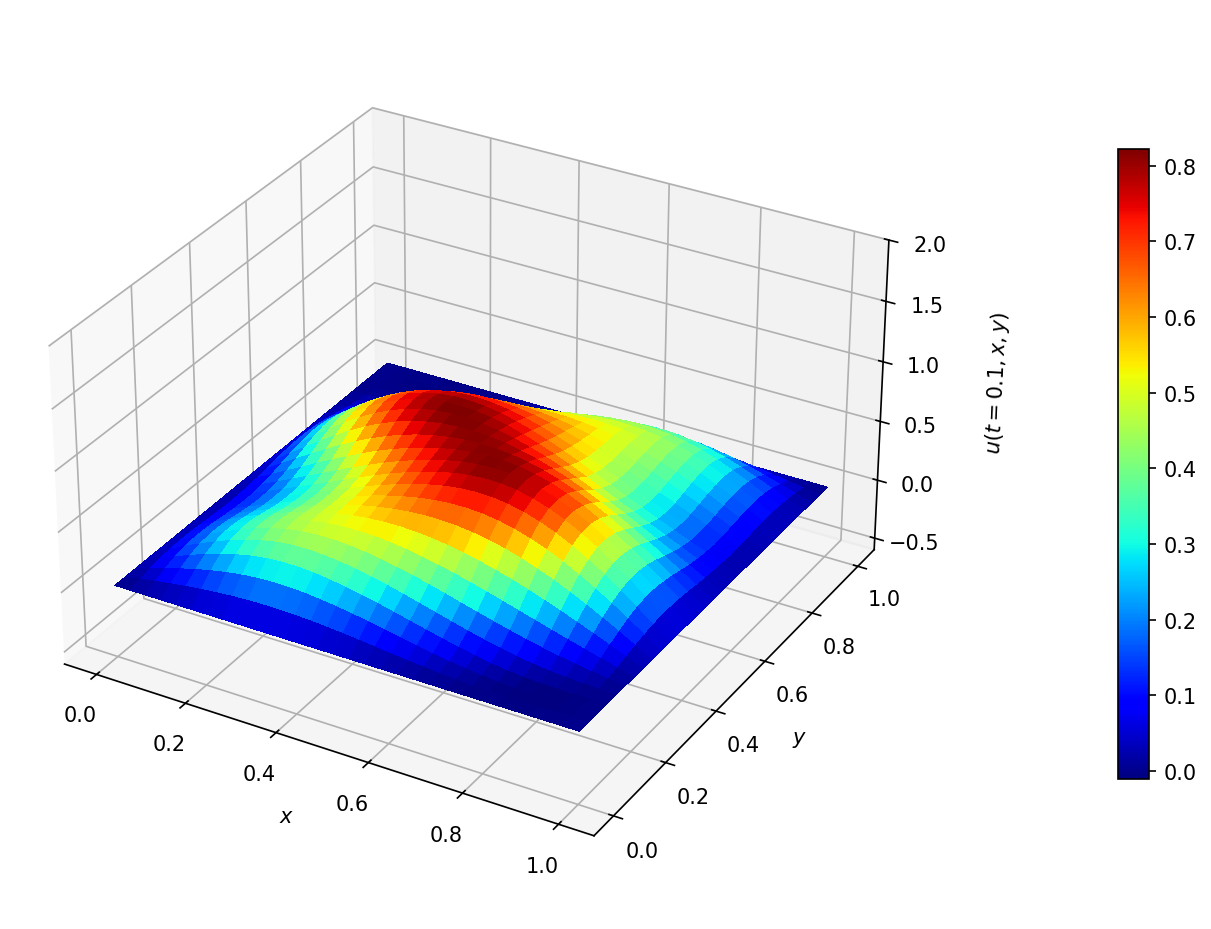

L^2 error:         0.0034342364
L_^{infty}_error:  0.01319921


In [9]:
### 3D plot of the solution obtained by our neural network

for t in [0.01, 0.1]:
    # 2D grid
    x = np.linspace(0, 1, N_colloc)
    y = np.linspace(0, 1, N_colloc)
    X, Y = np.meshgrid(x, y)

    # convert grid to NN input (400x1)
    x_test = torch.tensor(X.reshape(-1, 1), dtype=torch.float32)
    y_test = torch.tensor(Y.reshape(-1, 1), dtype=torch.float32)

    t_test = torch.tensor([[t]] * (N_colloc**2), dtype=torch.float32)

    # prediction: shape (400,1)
    u_pred = pde_nn.trial_solution(x_test, y_test, t_test).detach().numpy()

    # reshape to (20,20)
    u_pred = u_pred.reshape(N_colloc, N_colloc)

    # surface plot
    fig = plt.figure(figsize=(9, 6), dpi=150)
    ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], projection="3d")
    surf = ax.plot_surface(X, Y, u_pred, rstride=1, cstride=1, cmap=cm.jet,
                    linewidth=0, antialiased=False)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_zlabel(r'$u(t={}, x, y)$'.format(t), labelpad=12)
    ax.set_zlim(-0.6, 2.0)
    ax.set_position([0, 0, 1, 1])
    ax.set_box_aspect((1, 1, 0.6))

    mappable = surf
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.7, pad=0.15)

    # plt.colorbar()
    fig.canvas.draw()
    plt.savefig("surface.png", bbox_inches="tight", dpi=150)
    plt.show()

### error measured in L^2 and L^{\infty} norm
L_2_err = pde_nn.L_2_error()
L_infty_err = pde_nn.L_infty_error()
print("L^2 error:        ", L_2_err)
print("L_^{infty}_error: ", L_infty_err)

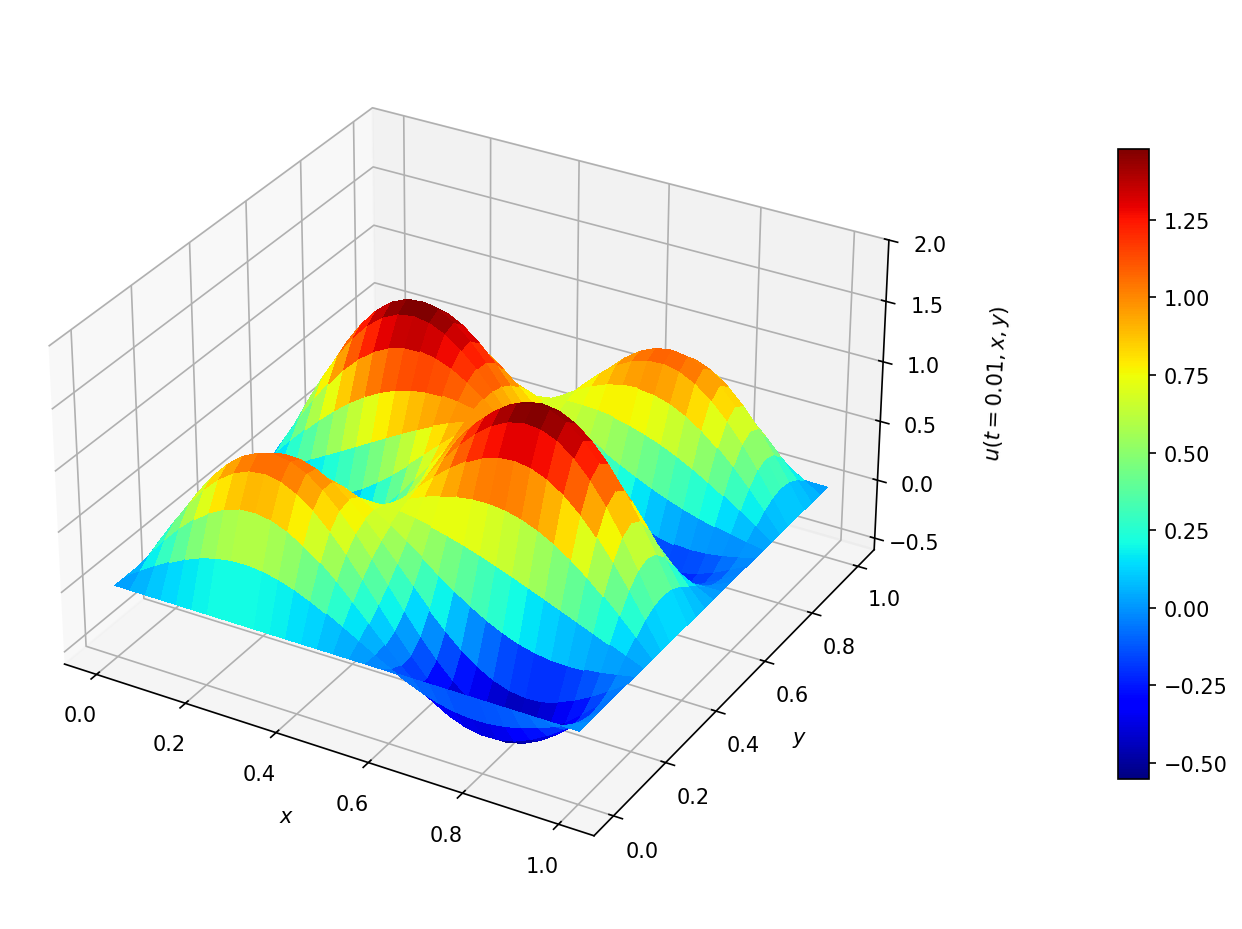

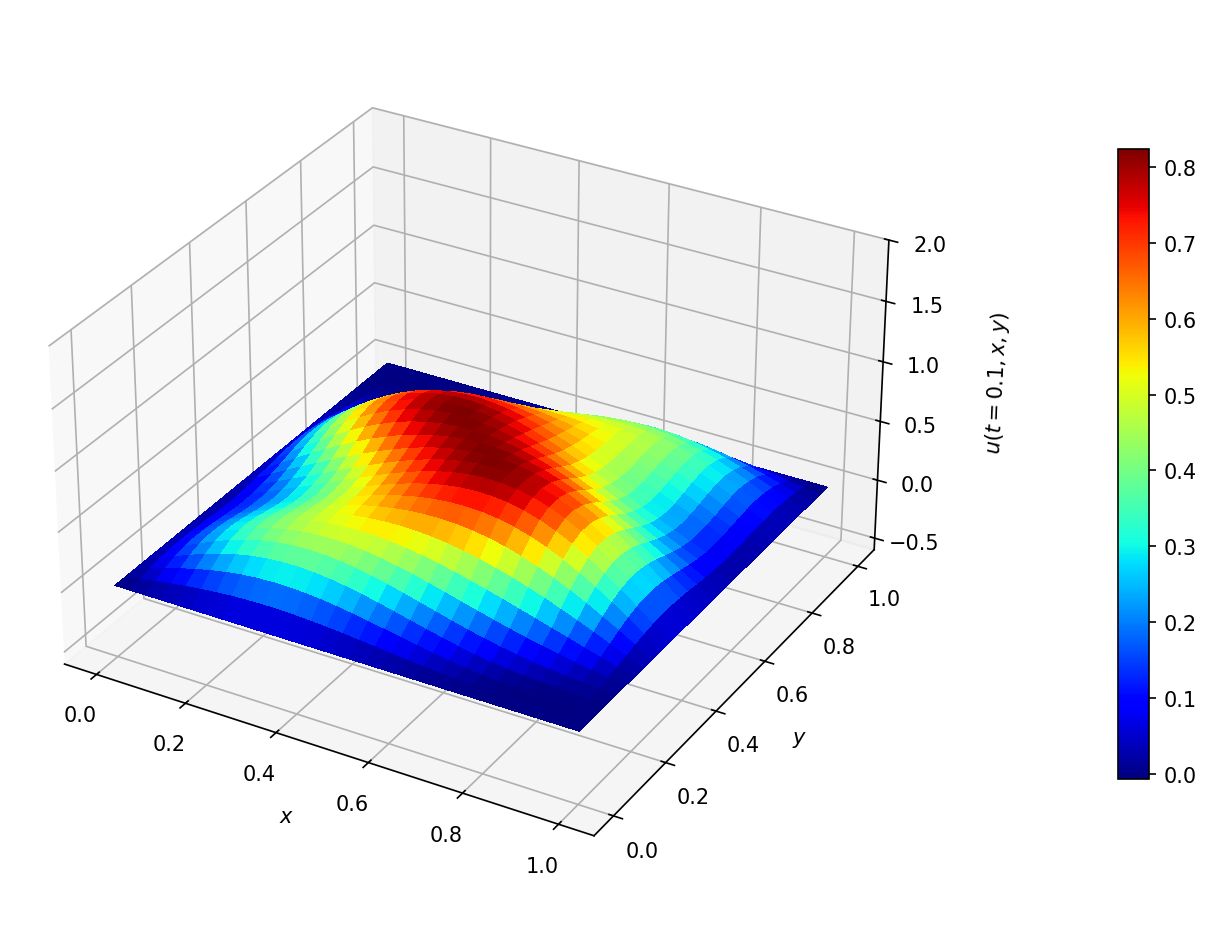

In [7]:
### 3d Plot of the analytic solution for comparison

for t in [0.01, 0.1]:
    # 2D grid
    x = np.linspace(0, 1, N_colloc)
    y = np.linspace(0, 1, N_colloc)
    X, Y = np.meshgrid(x, y)
    
    # convert grid to NN input (400x1)
    x_test = torch.tensor(X.reshape(-1, 1), dtype=torch.float32)
    y_test = torch.tensor(Y.reshape(-1, 1), dtype=torch.float32)

    t_test = torch.tensor([[t]] * (N_colloc**2), dtype=torch.float32)

    # prediction: shape (N_colloc ** 2,1)
    Z = u_analytic(x_test, y_test, t_test).detach().numpy()
    # reshape to (N_colloc, N_colloc)
    Z = Z.reshape(N_colloc, N_colloc)

    # surface plot
    fig = plt.figure(figsize=(9, 6), dpi=150)
    ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], projection="3d")
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.jet,
                    linewidth=0, antialiased=False)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_zlabel(r'$u(t={}, x, y)$'.format(t), labelpad=12)
    ax.set_zlim(-0.6, 2.0)
    ax.set_position([0, 0, 1, 1])
    ax.set_box_aspect((1, 1, 0.6))

    mappable = surf
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.7, pad=0.15)

    # plt.colorbar()
    fig.canvas.draw()
    plt.savefig("surface.png", bbox_inches="tight", dpi=150)
    plt.show()

In [8]:
print(pde_nn.mse())
print(pde_nn.mse(x_test, y_test, t_test))

1.1793979e-05
2.3380302e-05
